In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colormaps as cm
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [60]:
def readSetupFromHDF5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as file:
        # Accessing the first element and converting to scalar
        Re = file['Re'][()].item()
        NX = int(file['NX'][()].item())
        NY = int(file['NY'][()].item())
        LX = file['LX'][()].item()
        LY = file['LY'][()].item()
        L = file['L'][()].item()
        U = file['U'][()].item()
        nu = file['nu'][()].item()
        dx = file['dx'][()].item()
        dy = file['dy'][()].item()
        dt = file['dt'][()].item()
        T = file['T'][()].item()
        w_on = bool(file['w_on'][()].item())
        animation_on = bool(file['animation_on'][()].item())
    return Re, NX, NY, LX, LY, L, U, nu, dx, dy, dt, T, w_on, animation_on


def readSolutionFromHDF5(hdf5_file):
    with h5py.File(hdf5_file, 'r') as file:
        # NX = int(file['NX'][()].item())
        # NY = int(file['NY'][()].item())
        u = file['u'][:]
        v = file['v'][:]
        w = file['w'][:]
        p = file['p'][:]
        t = file['t'][()].item()
    return t, u, v, w, p


X_LABEL = 'x'
Y_LABEL = 'y'
Z_LABEL = 'z'
FONTSIZE_TIME = 10
y_pos_text = 1.03
y_pos_title = y_pos_text + 0.14
colorbar_args = {'shrink': 0.5, 'aspect': 10, 'location': 'left'}
duration = 10  # duration of the animation in seconds
cols_removed_beginning = 0
cols_removed_end = 20


def plot_slice(folder_path, slice):
    Re, NX, NY, LX, LY, L, U, nu, dx, dy, dt, T, w_on, animation_on = readSetupFromHDF5(
        '../output/setup.h5')
    num_frames = len([f for f in os.listdir(folder_path)
                     if os.path.isfile(os.path.join(folder_path, f))])
    times = []
    data_blocks_u = []
    data_blocks_v = []
    data_blocks_w = []
    data_blocks_p = []
    for i in range(num_frames):
        file_path = folder_path + 'sol_' + str(i) + '.h5'
        t, u, v, w, p = readSolutionFromHDF5(file_path)
        times.append(t)
        # remove ghost cells
        data_blocks_u.append(np.mean(u[slice, 1:-1]))
        data_blocks_v.append(np.mean(v[slice, 1:-1]))
        data_blocks_w.append(np.mean(w[slice, 1:-1]))
        data_blocks_p.append(np.mean(p[slice, 1:-1]))

    times = np.array(times)
    data_blocks_u = np.array(data_blocks_u)
    data_blocks_v = np.array(data_blocks_v)
    data_blocks_w = np.array(data_blocks_w)
    data_blocks_p = np.array(data_blocks_p)

    # change to whatever you want to plot
    data_blocks = data_blocks_w

    fig, ax = plt.subplots()
    ax.plot(times, data_blocks)
    plt.show()


def plot(folder_path, slice_time, object, vorticity): 
    Re, NX, NY, LX, LY, L, U, nu, dx, dy, dt, T, w_on, animation_on = readSetupFromHDF5(
        '../output/setup.h5')
    w_on = vorticity
    redblue = cm['RdBu_r']
    only_red = ListedColormap(redblue(np.linspace(0.5, 1, 128)))
    color = redblue if w_on else only_red

    num_frames = len([f for f in os.listdir(folder_path)
                     if os.path.isfile(os.path.join(folder_path, f))])
    
    if slice_time < 0 or slice_time >= num_frames:
        print("Slice time out of range")
        return
    
    file_path = folder_path + 'sol_' + str(slice_time) + '.h5'
    t, u, v, w, p = readSolutionFromHDF5(file_path)

    u = np.array(u)
    v = np.array(v)
    w = np.array(w)
    p = np.array(p)

    nx = NX - 2
    ny = NY - 2

    X = np.linspace(dx / 2 * (1 + cols_removed_beginning),
                    LX - dx / 2 * (1 + cols_removed_end), nx)
    Y = np.linspace(dy / 2, LY - dy / 2, ny)
    X, Y = np.meshgrid(X, Y, indexing='xy')

    # change to whatever you want to plot
    # remove ghost cells
    if w_on:
        data = w[1:-1, 1:-1].T[::-1]
    else:
        data = u[1:-1, 1:-1].T[::-1] ** 2 + v[1:-1, 1:-1].T[::-1] ** 2

    # delete the first cols_removed_beginning and last cols_removed_end columns (of data)
    data = np.delete(data, np.s_[:cols_removed_beginning], axis=1)
    data = np.delete(data, np.s_[-cols_removed_end:], axis=1)


    Z_MIN = np.min(data)
    Z_MAX = np.max(data)

    if w_on:
        Z_MIN /= 4
        Z_MAX /= 4

    plot_args = {
    'cmap': color,
    'extent': [
        dx * cols_removed_beginning,
        LX - dx * cols_removed_end,
        0,
        LY],
    'vmin': Z_MIN,
    'vmax': Z_MAX,
    # 'interpolation': 'none'}
    'interpolation': 'spline16'}

    fig, ax = plt.subplots()

    # Axes
    ax.set_xlabel(X_LABEL)
    ax.set_ylabel(Y_LABEL)
    plt.imshow(data, **plot_args)
     # plot a circle
    if object != "":
        if object == 'circle':
            x0 = LX / 8
            y0 = LY / 2
            radius = L/2
            obstacle = Circle((x0, y0), radius, color='black', fill=True)
            ax.add_artist(obstacle)
        elif object == 'rectangle':
            x0 = LX / 8
            y0 = LY / 2
            width = L
            height = L
            obstacle = Rectangle(
                    (x0 - width / 2, y0 - height / 2), width, height, color='black', fill=True)
            ax.add_artist(obstacle)
        elif object == 'mountain':
            # mountain is the 1D function f(x) = y0 - sqrt(lambda^2 (x - x0)^2
            # + h)
            x0 = 0.7
            y0 = 0.9
            lamb = 3.1
            h = 0.2
            obstacle = ax.plot(X[0],
                                   y0 - np.sqrt(lamb**2 * (X[0] - x0)**2 + h),
                                   color='black')
        elif object == 'airfoil':
            # airfoil is the 1D function f(x) = y0 + a * sqrt(x - x0) + b * (x
            # - x0) + c * (x - x0)^2 + d * (x - x0)^3 + e * (x - x0)^4
            a = 0.17814
            b = -0.0756
            c = -0.21096
            d = 0.17058
            e = -0.0609
            lamb = 0.2
            x0 = LX/8
            y0 = LY/2        
            XX = np.linspace(x0, x0 + 1, 5 * nx)
            obstacle = ax.plot(XX, y0 +
                                   a * np.sqrt(XX - x0) +
                                   b * (XX - x0) +
                                   c * (XX - x0)**2 +
                                   d * (XX - x0)**3 +
                                   e * (XX - x0)**4,
                                   color='black') + ax.plot(XX, y0 -
                                                            lamb * (a * np.sqrt(XX - x0) +
                                                                    b * (XX - x0) +
                                                                    c * (XX - x0)**2 +
                                                                    d * (XX - x0)**3 +
                                                                    e * (XX - x0)**4),
                                                            color='black')

    plt.colorbar()
    plt.show()

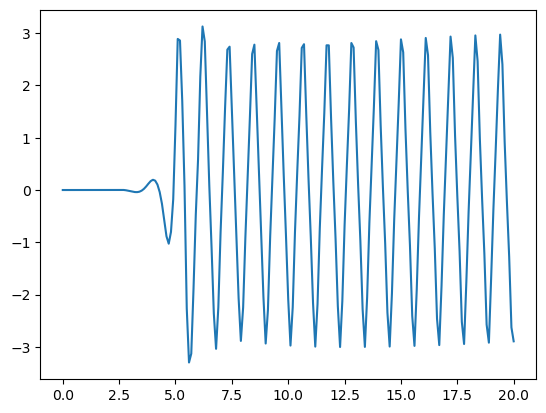

In [61]:
plot_slice("../output/results/",300)

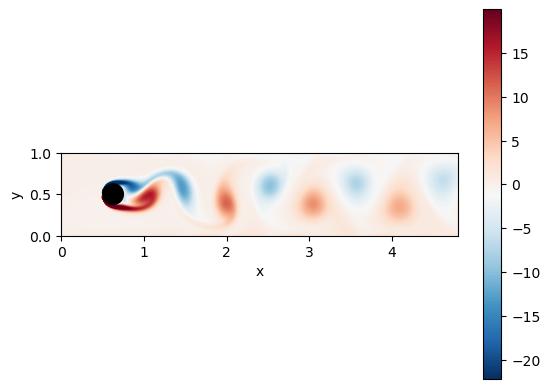

In [64]:
plot("../output/results/", 150, "circle",True)